<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/master/template-report-lab-X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Approximation**
**Hilaire Bouaddi**

# **Abstract**

The lab report will go through the implementation of an L2 piece wise linear approximation. As we'll see there are some improvements to be done and the implementation may contain some problems. 

# **Set up environment**

In [1]:
# Load neccessary modules.
import time
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

import scipy.integrate as integrate

# **Introduction**

The problem investigated here is the approximation of a function $f$. 

More precisely, we have $A\alpha = b$ with 

$
\begin{align*}
    a_{ij} &= (\phi_j,\phi_i) = \int_a^b{\phi_j(x)\phi_i(x) dx} \\
    b_{i} &= (f,\phi_i) = \int_a^b{f(x)\phi_i(x) dx}
\end{align*}
$ with $\{\phi_i\}_{i=1}^N$ being the base that span $V_N$

We will choose a base such that: 

$
\begin{align*}
    \phi_i(x) = 
    \begin{cases}
        \lambda_{k,1}(x), \; &x\in I_k,\\
        \lambda_{k+1, 0}(x), \; &x\in I_{k+1} \\
        0, &x \notin (I_k \cup I_{k+1})
    \end{cases}
\end{align*}
$

With all of this, we should be able to compute the $\alpha$ components and then the approximation for the given vector.



# **Method**

Here is the implementation of the functions 

In [85]:
# Input: function f(x), 1D mesh with nodes (x0,...,xn)
# Output: vector of L2 projection of f(x) evaluated in (x0,...,xn) 

def lagrange(k, i, x, elements): 
    # assuming even mesh
    h = elements[1] - elements[0]
    
    if i == 0:
        return (elements[k] - x) / h
    else: 
        return (x - elements[k-1]) / h
        

def phi(i, x, elements):
    # conditions at the endpoints
    if i == 0:
        if x<elements[1]:
            return lagrange(1, 0, x, elements)
        else:
            return 0
    if i == len(elements) - 1: 
        if x>elements[-2]:
            return lagrange(len(elements) - 1, 1, x, elements)
        else: 
            return 0
    
    # internal nodes
    if x<elements[i-1]:
        return 0
    elif x<elements[i]:
        # in I_k
        return lagrange(i, 1, x, elements)
    elif x<elements[i+1]:
        #in I_k+1
        return lagrange(i+1, 0, x, elements)
    else: 
        return 0 

def get_no_local_shape_functions(k, elements):
    if k == 0:
        return 1
    elif k == len(elements) - 1:
        return 1
    else: 
        return 2

def integrate_matrix(k, i, j, elements):
    # assuming that the mesh is even 
    h = elements[1] - elements[0]
    if i == j:
        return 2*h/3 
    elif abs(i-j) > 1:
        return 0
    else: 
        return h/6

    
    
def integrate_vector(f, k, i, elements):
    return integrate.quad(lambda x: f(x)*phi(k, x, elements), elements[0], elements[-1])[0]
    
def assemble_system(f, elements):
    A = np.zeros((len(elements), len(elements)))
    B = np.zeros(len(elements))
    for k in range(1, len(elements)): 
        q = get_no_local_shape_functions(k, elements)
        
        a = np.zeros((q+1, q+1))
        b = np.zeros(q+1)
        
        for i in range(q+1):
            b[i] = integrate_vector(f, k, i, elements)
            for j in range(q+1):
                a[i, j] = integrate_matrix(k, i, j, elements)
        
        if k == len(elements)-1:
            for i in range(-1, 1):
                B[k+i] += b[i+1]
                for j in range(-1, 1):
                    A[k+i, k+j] += a[i+1, j+1]
            
        else: 
            for i in range(-1, 2):
                B[k+i] += b[i+1]
                for j in range(-1, 2):
                    A[k+i, k+j] += a[i+1, j+1]

    
    return A, B

#Function: L2 projection to pw linear approximation over mesh in 1D
def L2_proj(f, elements): 
    
    A, B = assemble_system(f, elements)
    alphas = np.linalg.inv(A)@B
    results = []
    
    Xs = np.linspace(0, np.pi, len(elements))
    for x in Xs:

        summ = 0
        for i in range(len(elements)):
            summ += alphas[i]*phi(i, x, elements)

        results.append(summ)

    errors.append(np.linalg.norm(results-f(Xs)))

    return results, errors 
    


# **Results**

Present the results. If the result is an algorithm that you have described under the *Methods* section, you can present the data from verification and performance tests in this section. If the result is the output from a computational experiment this is where you present a selection of that data. 

Let's try to approximate $sin(x)$ and $cos(x)$ in $[0, \pi]$

In [86]:
class SinFunction:
    
    def __init__(self):
        self.name = "sinus"
    
    def __call__(self, x):
        return np.sin(x)

    
class CosFunction:
    
    def __init__(self):
        self.name = "cosinus"
    
    def __call__(self, x):
        return np.cos(x)
    

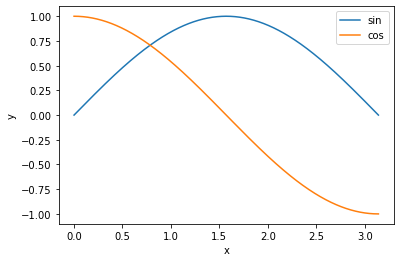

In [87]:
sin = SinFunction()
cos = CosFunction()

xs = np.linspace(0, np.pi, 1000)

plt.plot(xs, sin(xs), label="sin")
plt.plot(xs, cos(xs), label="cos")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


Text(0.5, 0.98, 'Approximation of sin and cosinus with the evolution of the error depending in the number of intervals')

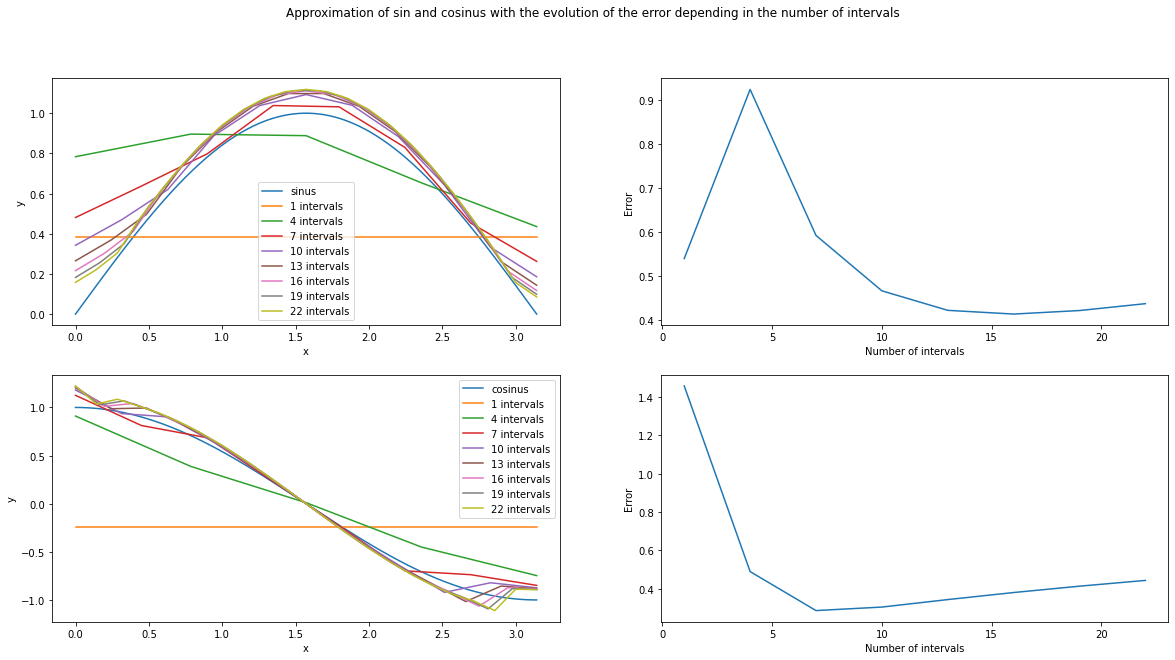

In [91]:
fs = [SinFunction(), CosFunction()]

plt.figure(figsize=(20, 10))

a = 0
b = np.pi



no_elements_range = range(2, 25, 3)

for f_index in range(len(fs)): 
    f = fs[f_index]
    
    plt.subplot(2,2,1+f_index*2)
    plt.plot(Xs, f(Xs), label=f.name)

    errors = []
    for no_elements in no_elements_range:

        elements = np.linspace(a, b, no_elements)

        results, errors = L2_proj(f, elements)
        
        plt.plot(elements, results, label=f"{no_elements - 1} intervals")
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

    plt.subplot(2,2,2+f_index*2)
    plt.xlabel("Number of intervals")
    plt.ylabel("Error")
    plt.plot(no_elements_range - np.ones(len(no_elements_range)), errors)
    
plt.suptitle("Approximation of sin and cosinus with the evolution of the error depending in the number of intervals")

# **Discussion**

The results are correct but there are some key points that are a bit off. First of all, we can see that the error is not strictly decreasing when we increase the number of intervals. This is probably due to a problem in the implementation since this error should decrease for the approximation of a continuous function such as sin or cos. 

Also, it looks like the algorithm diverges when there are too many intervals which would signal a problem somewhere. 